In [1]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

#import sys
#sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/train/'

In [2]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [3]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 46159 files belonging to 25 classes.
Using 36928 files for training.
Using 9231 files for validation.


2024-02-17 18:54:51.408935: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-17 18:54:51.409077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-17 18:54:51.409100: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-17 18:54:51.409610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-17 18:54:51.409948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import tensorflow.keras.backend as K
K.clear_session()

In [5]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [6]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [7]:
from keras import layers
IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [8]:
model = build_model(num_classes=25)

In [9]:
epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10


2024-02-17 18:56:43.030504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1154/1154 [==============================] - 325s 274ms/step - loss: 0.7572 - accuracy: 0.8620 - val_loss: 0.3245 - val_accuracy: 0.9300
Epoch 2/10
1154/1154 [==============================] - 343s 296ms/step - loss: 0.4300 - accuracy: 0.9048 - val_loss: 0.2359 - val_accuracy: 0.9394
Epoch 3/10
1154/1154 [==============================] - 338s 293ms/step - loss: 0.3841 - accuracy: 0.9091 - val_loss: 0.2718 - val_accuracy: 0.9388
Epoch 4/10
1154/1154 [==============================] - 337s 292ms/step - loss: 0.3976 - accuracy: 0.9088 - val_loss: 0.2469 - val_accuracy: 0.9404
Epoch 5/10
1154/1154 [==============================] - 332s 287ms/step - loss: 0.4192 - accuracy: 0.9106 - val_loss: 0.2977 - val_accuracy: 0.9313
Epoch 6/10
1154/1154 [==============================] - 320s 277ms/step - loss: 0.4483 - accuracy: 0.9100 - val_loss: 0.3272 - val_accuracy: 0.9386
Epoch 7/10
1154/1154 [==============================] - 318s 276ms/step - loss: 0.4459 - accuracy: 0.9118 - val_loss: 0.335

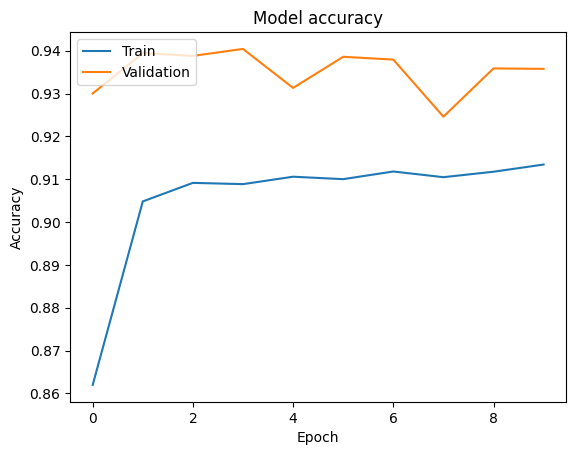

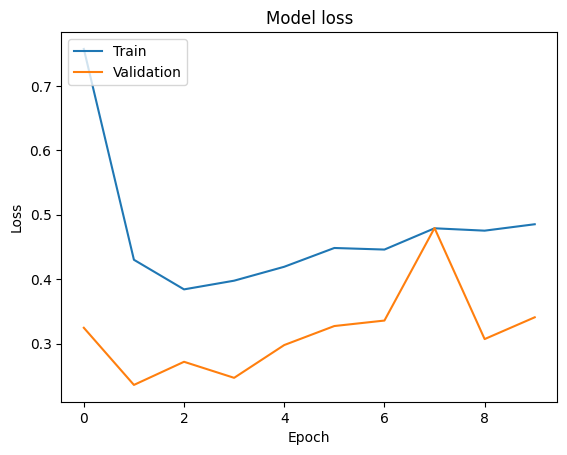

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


In [13]:
# Create a new model with unfrozen layers
unfrozen_model2 = unfreeze_model_and_clone(model)

epochs = 10
history2 = unfrozen_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
1154/1154 [==============================] - 325s 275ms/step - loss: 0.2938 - accuracy: 0.9365 - val_loss: 0.2279 - val_accuracy: 0.9558
Epoch 2/10
1154/1154 [==============================] - 327s 283ms/step - loss: 0.2176 - accuracy: 0.9498 - val_loss: 0.2114 - val_accuracy: 0.9586
Epoch 3/10
1154/1154 [==============================] - 326s 283ms/step - loss: 0.1914 - accuracy: 0.9522 - val_loss: 0.2049 - val_accuracy: 0.9602
Epoch 4/10
1154/1154 [==============================] - 323s 279ms/step - loss: 0.1800 - accuracy: 0.9547 - val_loss: 0.1983 - val_accuracy: 0.9598
Epoch 5/10
1154/1154 [==============================] - 335s 290ms/step - loss: 0.1733 - accuracy: 0.9557 - val_loss: 0.1880 - val_accuracy: 0.9617
Epoch 6/10
1154/1154 [==============================] - 341s 296ms/step - loss: 0.1564 - accuracy: 0.9583 - val_loss: 0.1844 - val_accuracy: 0.9615
Epoch 7/10
1154/1154 [==============================] - 354s 306ms/step - loss: 0.1472 - accuracy: 0.9609 - val_

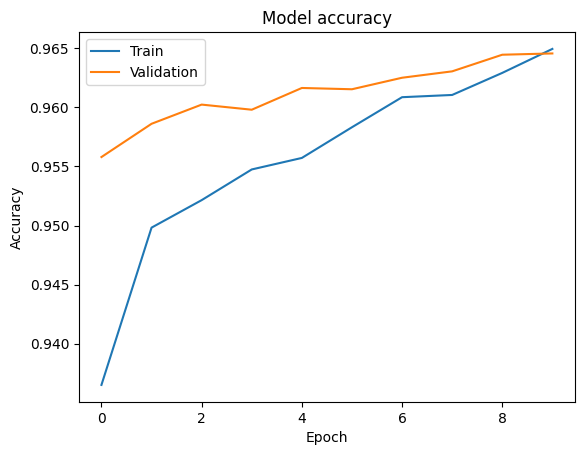

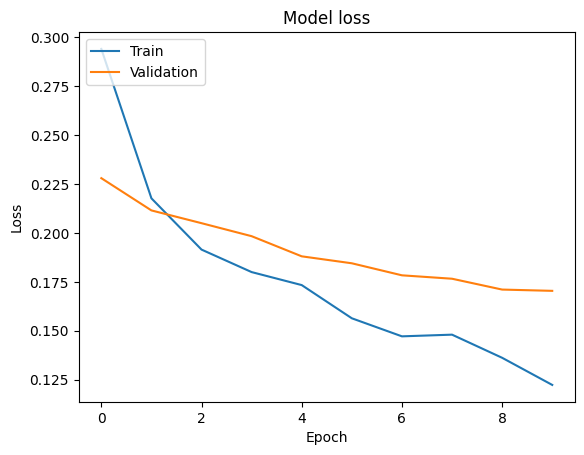

In [14]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

dataset_test_path = '../data/test/'

In [17]:
test_ds = load_test(dataset_test_path)

Found 11539 files belonging to 25 classes.


In [18]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25), dtype=tf.float32, name=None))>

In [19]:
# Make predictions on the test dataset
predictions = unfrozen_model2.predict(test_ds)

361/361 [==============================] - 84s 224ms/step


#### Plotting the results and getting evaluation metrics

In [20]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = unfrozen_model2.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)



361/361 [==============================] - 80s 220ms/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.92      0.91      0.92        54
      bacterial_spot       0.97      0.98      0.97      1070
       black_measles       0.97      0.98      0.98       470
           black_rot       0.99      0.96      0.98       392
          brown_spot       1.00      1.00      1.00        37
     citrus_greening       1.00      1.00      1.00      1080
         common_rust       1.00      1.00      1.00       260
        early_blight       0.92      0.87      0.89       191
      gray_leaf_spot       0.91      0.80      0.85        96
           gray_spot       0.90      0.75      0.82        75
             healthy       0.98      0.99      0.99      3373
isariopsis_leaf_spot       0.69      0.81      0.74       213
         late_blight       0.94      0.96      0.95       354
         leaf_blight       0.07      0.04      0.0

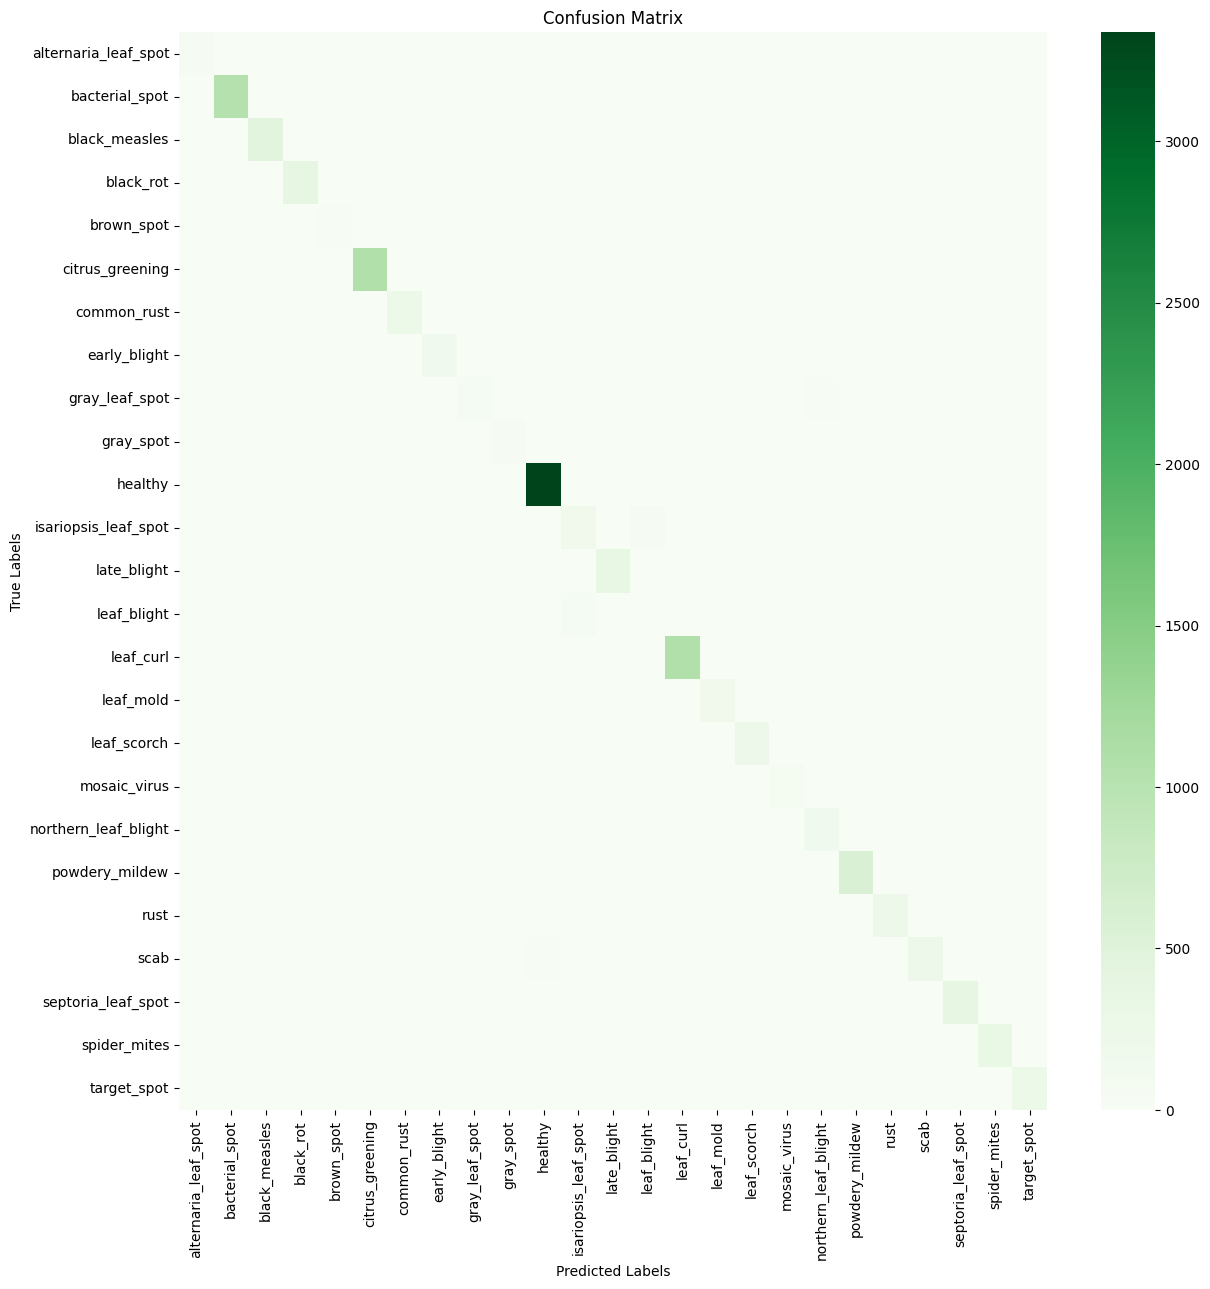

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()